## Preliminaries

### 1. Importing Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 2. Gathering Data

In [ ]:
data_url = "https://raw.githubusercontent.com/renatoquiliche/DataScience-PUCRio-FB/main/Data/DS_salarios/ds_salaries.csv"
data = pd.read_csv(data_url, index_col = 0)

* No need to convert to parquet dataset. The dataset is small.

### 3. Assessing Data

In [ ]:
data.head()

,work_year,work_month,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,6,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,11,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,12,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,6,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,10,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [ ]:
print("The number of rows are {} and columns are {}".format(data.shape[0], data.shape[1]))

The number of rows are 607 and columns are 12


In [ ]:
# List columns
data.columns

Index(['work_year', 'work_month', 'experience_level', 'employment_type',
       'job_title', 'salary', 'salary_currency', 'salary_in_usd',
       'employee_residence', 'remote_ratio', 'company_location',
       'company_size'],
      dtype='object')

In [ ]:
# Look for missing data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   work_month          607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 61.6+ KB


* There are no missing values.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f627c9490d0>]],
      dtype=object)

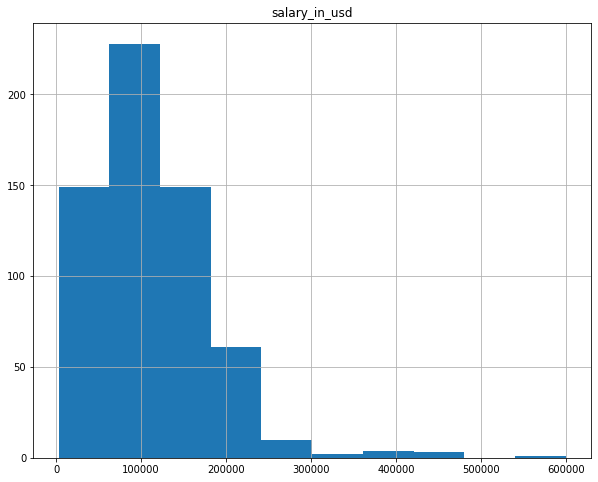

In [ ]:
data.hist(column=["salary_in_usd"],figsize = (10,8))

## Pre-processing

### 1. Resampling Data, estimating variable mean and value frequency via Bootsrapping

##### 1.1 Bootstrapping function

In [ ]:
def mean_bootstrap(series, B = 10000):
    return pd.Series([series.sample(n = len(series), replace = True).mean() for i in range(B)])

def frequency_bootstrap(series, value, B = 10000):
    
    T = pd.Series(data = 0, index = range(B))

    for i in range(B):
        
        sample = series.sample(n = len(series), replace = True)
        T_i = len(sample[sample == value])/len(series)
        T.loc[i] = T_i

    return T

##### 1.2 Mean Estimation

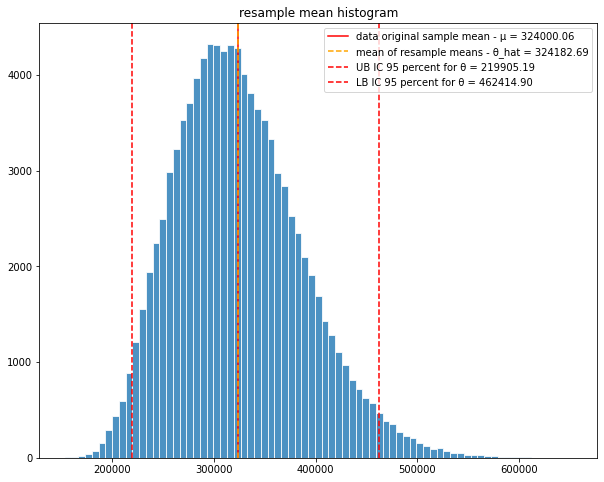

In [ ]:
frequency = mean_bootstrap(data.salary,100000)

fig,ax = plt.subplots(figsize = (10,8))


ax.set_title('resample mean histogram')
ax.axvline(data.salary.mean(), color = 'red', label = 'data original sample mean - µ = %.2f'%data.salary.mean())
ax.axvline(frequency.mean(), label = 'mean of resample means - θ_hat = %.2f'%frequency.mean(), color = 'orange',linestyle = 'dashed')
ax.axvline(frequency.quantile(q=0.025),label = 'UB IC 95 percent for θ = %.2f'%frequency.quantile(q=0.025), color = 'red', linestyle = 'dashed')
ax.axvline(frequency.quantile(q=0.975), label = 'LB IC 95 percent for θ = %.2f'%frequency.quantile(q=0.975), color = 'red', linestyle = 'dashed')
ax.hist(frequency, bins = 75, edgecolor = 'white', alpha = 0.8)
ax.legend()

plt.show()

##### 1.3 Frequency Estimation

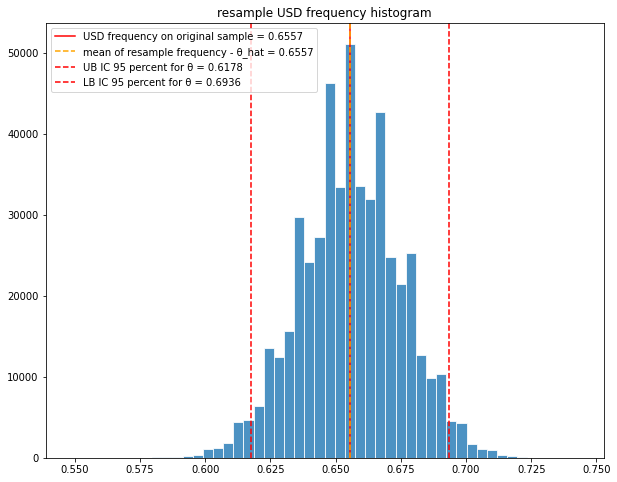

In [ ]:
value = 'USD'
frequency = frequency_bootstrap(data.salary_currency, value, 500000)
frq_original_sample = len(data[data.salary_currency == value]) / len(data)

fig,ax = plt.subplots(figsize = (10,8))

ax.set_title('resample %s frequency histogram'%value)
ax.hist(frequency, bins = 50, edgecolor = 'white', alpha = 0.8)
ax.axvline(frq_original_sample, color = 'red', label = '%s frequency on original sample = %.4f'%(value, frq_original_sample))
ax.axvline(frequency.mean(), label = 'mean of resample frequency - θ_hat = %.4f'%frequency.mean(), color = 'orange',linestyle = 'dashed')
ax.axvline(frequency.quantile(q=0.025),label = 'UB IC 95 percent for θ = %.4f'%frequency.quantile(q=0.025), color = 'red', linestyle = 'dashed')
ax.axvline(frequency.quantile(q=0.975), label = 'LB IC 95 percent for θ = %.4f'%frequency.quantile(q=0.975), color = 'red', linestyle = 'dashed')
ax.legend()

plt.show()

### 2. Quantile Discretization

In [ ]:
data['salary_discretized'] = pd.qcut(data.salary,10)
data[['salary','salary_discretized']]

,salary,salary_discretized
0,70000,"(60000.0, 80000.0]"
1,260000,"(237000.0, 30400000.0]"
2,85000,"(80000.0, 99020.0]"
3,20000,"(3999.999, 42720.0]"
4,150000,"(133928.0, 152600.0]"
...,...,...
602,154000,"(152600.0, 180000.0]"
603,126000,"(115000.0, 133928.0]"
604,129000,"(115000.0, 133928.0]"
605,150000,"(133928.0, 152600.0]"


### 3. Feature Engineering

In [ ]:
data['working_days_count'] = pd.to_datetime("2022-12-31") - pd.to_datetime(data.work_year.map(str) + '-' + data.work_month.map(str)) #suppose today is 2022/12/31
data['remote_work_days_count'] = data.remote_ratio/100 * data['working_days_count'] * 8/24 * 20/30 #suppose 8 hours of work a day, 20 days of work each month
data[['work_year', 'work_month', 'remote_ratio', 'working_days_count', 'remote_work_days_count']]

,work_year,work_month,remote_ratio,working_days_count,remote_work_days_count
0,2020,6,0,943 days,0 days 00:00:00
1,2020,11,0,790 days,0 days 00:00:00
2,2020,12,50,760 days,84 days 10:40:00
3,2020,6,0,943 days,0 days 00:00:00
4,2020,10,50,821 days,91 days 05:20:00
...,...,...,...,...,...
602,2022,5,100,244 days,54 days 05:20:00
603,2022,6,100,213 days,47 days 08:00:00
604,2022,11,0,60 days,0 days 00:00:00
605,2022,2,100,333 days,74 days 00:00:00
